# Custom Celebrity Recognition Using Amazon Rekognition

***
This notebook provides a walkthrough of recognizing custom celebrities using Amazon Rekognition. You will first index faces of custom celebrities and then use SearchFaces API (https://docs.aws.amazon.com/rekognition/latest/dg/API_SearchFacesByImage.html and https://docs.aws.amazon.com/rekognition/latest/dg/API_StartFaceSearch.html) with sample image and video to detect custom celebrities.

***

In [21]:
# Update boto3 to current version
#!conda upgrade -y boto3

In [22]:
#Check to ensure that current version of boto3 is installed
#import boto3
#print(boto3.__version__)

# Initialize Stuff
***

In [23]:
# initialise Notebook
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os
from io import BytesIO

In [24]:
# Get current region to choose correct bucket
mySession = boto3.session.Session()
awsRegion = mySession.region_name

In [25]:
# Initialize clients
rekognition = boto3.client('rekognition')
dynamodb = boto3.client('dynamodb')
s3 = boto3.client('s3')

In [26]:
# S3 bucket that contains sample images and videos

# We are providing sample images and videos in this bucket so
# you do not have to manually download/upload test images and videos.
bucketName = "aws-workshops-" + awsRegion

In [27]:
# DynamoDB Table and Rekognition Collection names. We will be creating these in this module.
ddbTableName = "my-celebrities"
collectionId = "my-celebrities"

In [28]:
# Create temporary directory
# This directory is not needed to call Rekognition APIs.
# We will only use this directory to download images from S3 bucket and drwaw bounding boxes
# around recognized celebrities to show them here in the notebook.

!mkdir m2tmp
tempFolder = 'm2tmp/'

mkdir: cannot create directory ‘m2tmp’: File exists


# DynamoDB table to store custom celebrity metadata
***
In this step we will create a DynamoDB table to store custom celebrity metadata including id, name and url. You can store additional attributes for each celebrity if needed.

#### List existing DynamoDB tables in your account

In [29]:
# List existing DynamoDB Tables
# Before creating DynamoDB table, let us firsr look at the list of existing DynamoDB tables in our account.

listTablesResponse = dynamodb.list_tables()
display(listTablesResponse["TableNames"])

['Approvals',
 'DLApprovals',
 'Forms',
 'HSBC',
 'MediaPipeline-TableCD117FA1-IW432ZR75ZF',
 'OnlineStoreProductReviews',
 'OnlineStoreProducts',
 'People',
 'Products',
 'RekogFacesRekogDemo',
 'RekogSentimentRekogDemo',
 'RekognitionPipelineStack-RekognitionOutputFC43104D-DKI5DFS20CYF',
 'TestAutoscaling',
 'TestNewTable',
 'TextractPipeline-DocumentsTable7E808EE5-1KBWG439FM6SV',
 'TextractPipeline-OutputTable875D8E18-B2GNAMNJVX06',
 'V047TextractDemo-V047TextractDemoDocumentsTable30EFB2A5-1DM6WY9FA7EL5',
 'V047TextractDemo-V047TextractDemoOutputTableDCBAD3C4-FLPO9MIFZO81',
 'kinesis',
 'korean-celebrities',
 'mes-jobs',
 'modsol-configurations',
 'modsol-jobs',
 'my-celebrities',
 'nbc-celebrities',
 'rekognise-faces',
 'rekognition-demo-ddbTable-1CIHQM2G1EDUM',
 'rekognize-faces',
 'test',
 'test-jobs']

#### Create new DynamoDB Table

In [30]:
# Create new DynamoDB Table
        
createTableResponse = dynamodb.create_table(
    TableName=ddbTableName,
    KeySchema=[
        {
            'AttributeName': 'id',
            'KeyType': 'HASH'  #Partition key
        }
    ],
    AttributeDefinitions=[
        {
            'AttributeName': 'id',
            'AttributeType': 'S'
        },

    ],
    ProvisionedThroughput={
        'ReadCapacityUnits': 10,
        'WriteCapacityUnits': 10
    }
)

display(createTableResponse)

ResourceInUseException: An error occurred (ResourceInUseException) when calling the CreateTable operation: Table already exists: my-celebrities

#### List DynamoDB Tables in your account to see newly created table 

In [31]:
# List DynamoDB Tables
# Let us look at list of our DynamoDB tables again to make sure that table we just created appears in the list.

listTablesResponse = dynamodb.list_tables()
display(listTablesResponse["TableNames"])

['Approvals',
 'DLApprovals',
 'Forms',
 'HSBC',
 'MediaPipeline-TableCD117FA1-IW432ZR75ZF',
 'OnlineStoreProductReviews',
 'OnlineStoreProducts',
 'People',
 'Products',
 'RekogFacesRekogDemo',
 'RekogSentimentRekogDemo',
 'RekognitionPipelineStack-RekognitionOutputFC43104D-DKI5DFS20CYF',
 'TestAutoscaling',
 'TestNewTable',
 'TextractPipeline-DocumentsTable7E808EE5-1KBWG439FM6SV',
 'TextractPipeline-OutputTable875D8E18-B2GNAMNJVX06',
 'V047TextractDemo-V047TextractDemoDocumentsTable30EFB2A5-1DM6WY9FA7EL5',
 'V047TextractDemo-V047TextractDemoOutputTableDCBAD3C4-FLPO9MIFZO81',
 'kinesis',
 'korean-celebrities',
 'mes-jobs',
 'modsol-configurations',
 'modsol-jobs',
 'my-celebrities',
 'nbc-celebrities',
 'rekognise-faces',
 'rekognition-demo-ddbTable-1CIHQM2G1EDUM',
 'rekognize-faces',
 'test',
 'test-jobs']

# Rekogniton Collection to store faces
***
In this step we will create a Rekognition Collection.

Amazon Rekognition can store information about detected faces in server-side containers known as [collections](https://docs.aws.amazon.com/rekognition/latest/dg/collections.html). You can use the facial information that's stored in a collection to search for known faces in images, stored videos, and streaming videos. In this section you will learn how you can create and manage Rekognition Collections.

#### List Rekognition Collections

In [32]:
#List Rekognition Collections
# Let us first see if we have already created any Rekognition collections in our account.
# If there is not an existing Rekognition in your account, you will see empty list
# otherwise you will a list with names of rekognition collections and face model version.

listCollectionsResponse = rekognition.list_collections()

display(listCollectionsResponse["CollectionIds"])
display(listCollectionsResponse["FaceModelVersions"])

['0802776c-8abb-4488-99d4-287cf2a17caa',
 '143cb0fb-fbe8-4273-941a-5b861cbfbe4b',
 '1d7defd6-c3a2-48db-a0a6-dafbc3af1962',
 'RekogDemo',
 'aiweek',
 'dl-faces',
 'ki-celebrities',
 'korean-celebrities',
 'my-celebrities',
 'nbc-celebrities',
 'people',
 'us-east-1-4bacc8e2-e8d4-4e86-bc8f-0e2811591060',
 'us-east-1-a09f0455-9707-4a9f-b6e4-2bef6b63c30c',
 'us-east-1-d5c41187-20ef-49e3-a457-2587ec0eb3d0']

['4.0',
 '4.0',
 '4.0',
 '4.0',
 '2.0',
 '2.0',
 '3.0',
 '3.0',
 '3.0',
 '3.0',
 '3.0',
 '4.0',
 '3.0',
 '3.0']

#### Create new Rekognition collection

In [33]:
# Create Rekognition Collection
# Let us now create a new Rekognition collection that we will use to store faces of custom celebrities.

createCollectionResponse = rekognition.create_collection(
    CollectionId=collectionId
)
display(createCollectionResponse)


ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreateCollection operation: The collection id: my-celebrities already exists

#### List Rekognition collections to see newly created Rekognition collection

In [34]:
# List Rekognition Collections
# Let us make sure that Recognition we just created now appears in the list of collections in our AWS account.
listCollectionsResponse = rekognition.list_collections()

display(listCollectionsResponse["CollectionIds"])
display(listCollectionsResponse["FaceModelVersions"])

['0802776c-8abb-4488-99d4-287cf2a17caa',
 '143cb0fb-fbe8-4273-941a-5b861cbfbe4b',
 '1d7defd6-c3a2-48db-a0a6-dafbc3af1962',
 'RekogDemo',
 'aiweek',
 'dl-faces',
 'ki-celebrities',
 'korean-celebrities',
 'my-celebrities',
 'nbc-celebrities',
 'people',
 'us-east-1-4bacc8e2-e8d4-4e86-bc8f-0e2811591060',
 'us-east-1-a09f0455-9707-4a9f-b6e4-2bef6b63c30c',
 'us-east-1-d5c41187-20ef-49e3-a457-2587ec0eb3d0']

['4.0',
 '4.0',
 '4.0',
 '4.0',
 '2.0',
 '2.0',
 '3.0',
 '3.0',
 '3.0',
 '3.0',
 '3.0',
 '4.0',
 '3.0',
 '3.0']

#### View additional information about the collection we just created

In [35]:
#Describe Rekognition Collection
# You can use DescribeCollection to get information, 
# such as the number of faces indexed into a collection 
# and the version of the model used by the collection for face detection etc.
# https://docs.aws.amazon.com/rekognition/latest/dg/API_DescribeCollection.html

# Since we have not indexed any faces yet, you should see FaceCount: 0

describeCollectionResponse = rekognition.describe_collection(
    CollectionId=collectionId
)
display(describeCollectionResponse)

{'FaceCount': 20,
 'FaceModelVersion': '3.0',
 'CollectionARN': 'arn:aws:rekognition:us-east-1:645849832089:collection/my-celebrities',
 'CreationTimestamp': datetime.datetime(2018, 10, 5, 18, 44, 59, 687000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '9c5b6e31-5e65-431b-9192-e590bebd8aa5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 14 Oct 2019 22:39:36 GMT',
   'x-amzn-requestid': '9c5b6e31-5e65-431b-9192-e590bebd8aa5',
   'content-length': '165',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Index Custom Celebrity Faces
***

In this step, you will index faces of custom celebrities in Rekognition collection and store their additional information in the DynamoDB table created in earlier steps.

We will index multiple images for each celebrity. By indexing multiple faces we increase the likelyhood of detecting celebrities when their face is in different angles etc. We will use [IndexFaces](https://docs.aws.amazon.com/rekognition/latest/dg/API_IndexFaces.html) to detects faces in the input image and add them to the specified collection.

You can read more about some of the best practices around [indexing faces here in the blog](https://aws.amazon.com/blogs/machine-learning/save-time-and-money-by-filtering-faces-during-indexing-with-amazon-rekognition/).

#### Define methods to add face to Rekognition collection and add related attributes to DynamoDB

In [36]:
# We will define a method to index a face along with the celebrity id
# https://docs.aws.amazon.com/rekognition/latest/dg/API_IndexFaces.html

def indexFace (bucketName, imageName, celebrityId):

    indexFaceResponse = rekognition.index_faces(
        CollectionId=collectionId,
        Image={
            'S3Object': {
                'Bucket': bucketName,
                'Name': imageName,
            }
        },
        ExternalImageId=celebrityId,
        DetectionAttributes=[
            'DEFAULT' #'DEFAULT'|'ALL',
        ],
        MaxFaces=1,
        QualityFilter='AUTO' #'NONE'|'AUTO'
    )
    
    display(indexFaceResponse)

# We will define a method to write metadata (id, name, url) of celebrity to DynamoDB
def addCelebrityToDynamoDB(celebrityId, celebrityName, celebrityUrl):
    ddbPutItemResponse = dynamodb.put_item(
        Item={
            'id': {'S': celebrityId},
            'name': {'S': celebrityName},
            'url': { 'S': celebrityUrl},
        },
        TableName=ddbTableName,
    )

## Index first celebrity

In [37]:
#Index Celebrity 1
celebrityId = "1"
celebrityName = "Chris Munns"
celebrityUrl = "http://www.amazon.com"

In [38]:
addCelebrityToDynamoDB(celebrityId, celebrityName, celebrityUrl)

#### Index face 1

In [39]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': "celebrity-rekognition/media/chris01.png"})))

In [40]:
# After you run this cell, biggest face from the image will be indexed.
# You will get JSON response with a variety of information but notice FaceId, ImageId and ExternalImageId
# Later when we will search celebrities, we will use this ExteralImageId to extract metadata from DynamoDB.

indexFace(bucketName, "celebrity-rekognition/media/chris01.png", celebrityId)

{'FaceRecords': [{'Face': {'FaceId': '8e751148-6d43-4c20-8c07-92cbde06430e',
    'BoundingBox': {'Width': 0.6603131294250488,
     'Height': 0.481389582157135,
     'Left': 0.17699114978313446,
     'Top': 0.13399504125118256},
    'ImageId': 'd3859cc6-84fa-52ac-bc78-f443c161b45b',
    'ExternalImageId': '1',
    'Confidence': 99.9993896484375},
   'FaceDetail': {'BoundingBox': {'Width': 0.6603131294250488,
     'Height': 0.481389582157135,
     'Left': 0.17699114978313446,
     'Top': 0.13399504125118256},
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.4026842713356018,
      'Y': 0.3198918402194977},
     {'Type': 'eyeRight', 'X': 0.6105719208717346, 'Y': 0.31991589069366455},
     {'Type': 'nose', 'X': 0.513560950756073, 'Y': 0.4127587676048279},
     {'Type': 'mouthLeft', 'X': 0.4069381654262543, 'Y': 0.47817501425743103},
     {'Type': 'mouthRight', 'X': 0.6016272902488708, 'Y': 0.4799521565437317}],
    'Pose': {'Roll': -0.7986788749694824,
     'Yaw': 5.43648099899292,
     

#### Index face 2

In [41]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': "celebrity-rekognition/media/chris02.png"})))

In [42]:
indexFace(bucketName, "celebrity-rekognition/media/chris02.png", celebrityId)

{'FaceRecords': [{'Face': {'FaceId': '2de10d6b-3ae5-4a0f-b9c8-f51f067025a3',
    'BoundingBox': {'Width': 0.40909090638160706,
     'Height': 0.4184472858905792,
     'Left': 0.3304195702075958,
     'Top': 0.172720804810524},
    'ImageId': '9029a5e2-7eee-5f37-95c5-1f8230884241',
    'ExternalImageId': '1',
    'Confidence': 99.99930572509766},
   'FaceDetail': {'BoundingBox': {'Width': 0.40909090638160706,
     'Height': 0.4184472858905792,
     'Left': 0.3304195702075958,
     'Top': 0.172720804810524},
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.4778355360031128,
      'Y': 0.3365987539291382},
     {'Type': 'eyeRight', 'X': 0.6037891507148743, 'Y': 0.3475469648838043},
     {'Type': 'nose', 'X': 0.544670820236206, 'Y': 0.4216906726360321},
     {'Type': 'mouthLeft', 'X': 0.48209577798843384, 'Y': 0.49356237053871155},
     {'Type': 'mouthRight', 'X': 0.5811835527420044, 'Y': 0.5018754005432129}],
    'Pose': {'Roll': 3.9359560012817383,
     'Yaw': 6.349170207977295,
     '

#### Index face 3

In [43]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': "celebrity-rekognition/media/chris03.png"})))

In [44]:
indexFace(bucketName, "celebrity-rekognition/media/chris03.png", celebrityId)

{'FaceRecords': [{'Face': {'FaceId': '2b03dff0-f81d-443a-8d9e-6915e0119f64',
    'BoundingBox': {'Width': 0.4301859140396118,
     'Height': 0.4281567633152008,
     'Left': 0.2861829996109009,
     'Top': 0.14876632392406464},
    'ImageId': 'f7f061a9-87af-50ee-af17-479b4254e505',
    'ExternalImageId': '1',
    'Confidence': 99.99998474121094},
   'FaceDetail': {'BoundingBox': {'Width': 0.4301859140396118,
     'Height': 0.4281567633152008,
     'Left': 0.2861829996109009,
     'Top': 0.14876632392406464},
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.44110965728759766,
      'Y': 0.31060630083084106},
     {'Type': 'eyeRight', 'X': 0.5737808346748352, 'Y': 0.3129110038280487},
     {'Type': 'nose', 'X': 0.5050837397575378, 'Y': 0.3926987946033478},
     {'Type': 'mouthLeft', 'X': 0.4502719044685364, 'Y': 0.4759613275527954},
     {'Type': 'mouthRight',
      'X': 0.5502656698226929,
      'Y': 0.48141103982925415}],
    'Pose': {'Roll': 0.4576975107192993,
     'Yaw': 1.1742099

In [45]:
# Describe Rekognition Collection
# With three faces indexed for celebrity 1, you shoud now see FaceCount: 3

describeCollectionResponse = rekognition.describe_collection(
    CollectionId=collectionId
)
display("FaceCount: {0}".format(describeCollectionResponse["FaceCount"]))

'FaceCount: 20'

### Index second celebrity

In [46]:
#Index Celebrity 2
celebrityId = "2"
celebrityName = "Kashif Imran"
celebrityUrl = "http://aws.amazon.com"

In [47]:
addCelebrityToDynamoDB(celebrityId, celebrityName, celebrityUrl)

#### Index face 1

In [48]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': "celebrity-rekognition/media/kashif01.jpg"})))

In [49]:
indexFace(bucketName, "celebrity-rekognition/media/kashif01.jpg", celebrityId)

{'FaceRecords': [{'Face': {'FaceId': 'b1079f05-f188-49a0-851d-f4f6b7b409d3',
    'BoundingBox': {'Width': 0.4000000059604645,
     'Height': 0.4000000059604645,
     'Left': 0.38461539149284363,
     'Top': 0.07692307978868484},
    'ImageId': '4128e1ea-a4ca-5128-a658-22e91dd18671',
    'ExternalImageId': '2',
    'Confidence': 99.99996185302734},
   'FaceDetail': {'BoundingBox': {'Width': 0.4000000059604645,
     'Height': 0.4000000059604645,
     'Left': 0.38461539149284363,
     'Top': 0.07692307978868484},
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.5266316533088684,
      'Y': 0.2129378765821457},
     {'Type': 'eyeRight', 'X': 0.6574026346206665, 'Y': 0.2313738465309143},
     {'Type': 'nose', 'X': 0.6034520268440247, 'Y': 0.29917195439338684},
     {'Type': 'mouthLeft', 'X': 0.5213654637336731, 'Y': 0.3650980293750763},
     {'Type': 'mouthRight',
      'X': 0.6245071291923523,
      'Y': 0.38479864597320557}],
    'Pose': {'Roll': 6.671633720397949,
     'Yaw': 15.025120

In [50]:
#### Index face 2

In [51]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': "celebrity-rekognition/media/kashif02.jpg"})))

In [52]:
indexFace(bucketName, "celebrity-rekognition/media/kashif02.jpg", celebrityId)

{'FaceRecords': [{'Face': {'FaceId': 'ecf9863f-b3c6-44da-97bb-0b2ea6231bca',
    'BoundingBox': {'Width': 0.29993879795074463,
     'Height': 0.29993879795074463,
     'Left': 0.3611507713794708,
     'Top': 0.13466639816761017},
    'ImageId': 'e65887fb-48a7-5b8a-8789-c3203624f19d',
    'ExternalImageId': '2',
    'Confidence': 99.99993896484375},
   'FaceDetail': {'BoundingBox': {'Width': 0.29993879795074463,
     'Height': 0.29993879795074463,
     'Left': 0.3611507713794708,
     'Top': 0.13466639816761017},
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.47613388299942017,
      'Y': 0.25086209177970886},
     {'Type': 'eyeRight', 'X': 0.5731441378593445, 'Y': 0.24136364459991455},
     {'Type': 'nose', 'X': 0.5616828799247742, 'Y': 0.32250070571899414},
     {'Type': 'mouthLeft', 'X': 0.48431190848350525, 'Y': 0.36589673161506653},
     {'Type': 'mouthRight',
      'X': 0.5526183843612671,
      'Y': 0.36316874623298645}],
    'Pose': {'Roll': -8.436196327209473,
     'Yaw': 3

In [53]:
#### Index face 3

In [54]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': "celebrity-rekognition/media/kashif03.jpg"})))

In [55]:
indexFace(bucketName, "celebrity-rekognition/media/kashif03.jpg", celebrityId)

{'FaceRecords': [{'Face': {'FaceId': 'bc2ea5c0-14f4-40cc-9070-02dd7213baf0',
    'BoundingBox': {'Width': 0.3938327431678772,
     'Height': 0.5364072322845459,
     'Left': 0.4441092610359192,
     'Top': 0.1940196305513382},
    'ImageId': 'c0717882-4691-594f-bbda-8c522dd71075',
    'ExternalImageId': '2',
    'Confidence': 99.99999237060547},
   'FaceDetail': {'BoundingBox': {'Width': 0.3938327431678772,
     'Height': 0.5364072322845459,
     'Left': 0.4441092610359192,
     'Top': 0.1940196305513382},
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.5864139199256897,
      'Y': 0.37581974267959595},
     {'Type': 'eyeRight', 'X': 0.7191605567932129, 'Y': 0.39563876390457153},
     {'Type': 'nose', 'X': 0.6562912464141846, 'Y': 0.48353585600852966},
     {'Type': 'mouthLeft', 'X': 0.5830775499343872, 'Y': 0.564542293548584},
     {'Type': 'mouthRight', 'X': 0.6952908635139465, 'Y': 0.5777515769004822}],
    'Pose': {'Roll': 5.631660461425781,
     'Yaw': 5.595746994018555,
     '

In [56]:
# Describe Rekognition Collection
# You should now have FaceCount: 6 since we have indexed 3 faces for each of the 2 celebrities we indexed.
describeCollectionResponse = rekognition.describe_collection(
    CollectionId=collectionId
)
display("FaceCount: {0}".format(describeCollectionResponse["FaceCount"]))

'FaceCount: 20'

## Recognize custom celebrities in image
***
Now let us try the image with custom celebtiries and see if we can recognize people in that image.


In [57]:
imageName = "celebrity-rekognition/media/serverless-bytes.png"

In [58]:
display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': imageName})))

#### Call Rekognition to recognize custom celebrity in image by using face search

In [59]:
searchFacesResponse = rekognition.search_faces_by_image(
    CollectionId=collectionId,
    Image={
        'S3Object': {
            'Bucket': bucketName,
            'Name': imageName,
        }
    },
    MaxFaces=2,
    FaceMatchThreshold=95
)

#### Review raw JSON response of search face by image API call

In [60]:
# You will see Rekognition response with SearchedFaceBoundingBox (which contains information about the biggest face
# in the image). Rekognition also returns FaceMatches, a list of matched faces. Each matched face has additional
# information including FaceId, ImageId and ExternalImageId. We will use ExternalImageId to extract information
# from DynamoDB about this celebrity.

display(searchFacesResponse)

{'SearchedFaceBoundingBox': {'Width': 0.14777778089046478,
  'Height': 0.3192000091075897,
  'Left': 0.19111111760139465,
  'Top': 0.19200000166893005},
 'SearchedFaceConfidence': 99.99990844726562,
 'FaceMatches': [{'Similarity': 99.69386291503906,
   'Face': {'FaceId': '8b525915-0a45-47c9-a2c3-60e7442d4820',
    'BoundingBox': {'Width': 0.8505589962005615,
     'Height': 0.6970289945602417,
     'Left': 0.12199299782514572,
     'Top': 0.19161300361156464},
    'ImageId': '2ad4f999-ea73-534c-8b0b-01e0d541c177',
    'ExternalImageId': '2',
    'Confidence': 100.0}},
  {'Similarity': 99.67900848388672,
   'Face': {'FaceId': '76b6cf63-ce3f-4755-b3ad-3059ebf4c7b6',
    'BoundingBox': {'Width': 0.7725899815559387,
     'Height': 0.6391810178756714,
     'Left': 0.198185995221138,
     'Top': 0.21306000649929047},
    'ImageId': 'de278503-8e7e-5b5a-8ca7-14a9381b5dde',
    'ExternalImageId': '2',
    'Confidence': 100.0}}],
 'FaceModelVersion': '3.0',
 'ResponseMetadata': {'RequestId': '3c3

#### Display image with bounding box around recognized custom celebrity

In [61]:
# Define functions to show image and bounded boxes around recognized celebrities
  
def displayWithBoundingBoxes (sourceImage, boxes):
    # blue, green, red, grey
    colors = ((220,220,220),(230,230,230),(76,182,252),(52,194,123))
    
    # Download image locally
    imageLocation = tempFolder+os.path.basename(sourceImage)

    s3.download_file(bucketName, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line= 3
    for box in boxes:
        x1 = int(box[1]['Left'] * width)
        y1 = int(box[1]['Top'] * height)
        x2 = int(box[1]['Left'] * width + box[1]['Width'] * width)
        y2 = int(box[1]['Top'] * height + box[1]['Height']  * height)
        
        draw.text((x1,y1),box[0],colors[col])
        for l in range(line):
            draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        col = (col+1)%maxcol
    
    imageFormat = "PNG"
    ext = sourceImage.lower()
    if(ext.endswith('jpg') or ext.endswith('jpeg')):
       imageFormat = 'JPEG'

    bbImage.save(imageLocation,format=imageFormat)

    display(bbImage)
    
def getDynamoDBItem(itemId):
    ddbGetItemResponse = dynamodb.get_item(
        Key={'id': {'S': itemId} },
        TableName=ddbTableName
    )
    
    itemToReturn = ('', '', '')
    
    if('Item' in ddbGetItemResponse):
        itemToReturn = (ddbGetItemResponse['Item']['id']['S'], 
                ddbGetItemResponse['Item']['name']['S'],
                ddbGetItemResponse['Item']['url']['S'])
    
    return itemToReturn



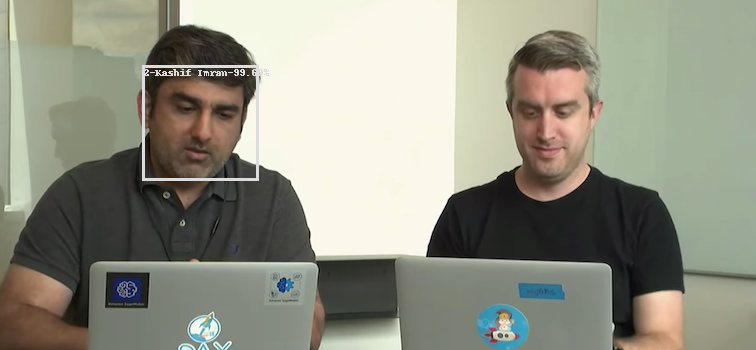

In [62]:
# After your run this cell you should see one of the faces recognized using Amazon Rekognition.
# You only see one face recognized in this example because
# SearchFacesByImage, for a given input image, first detects the largest face in the image,
# and then searches the specified collection for matching faces.

# In next section we will use DetectFaces API call to first detect faces in the image and then
# use SearchFacesByImage for each detected face to get it recognized.

def displaySearchedFace(sfr):  

    boxes = []
    
    if(len(sfr['FaceMatches']) > 0):
        bb = sfbb = sfr['SearchedFaceBoundingBox']
        eid = sfr['FaceMatches'][0]['Face']['ExternalImageId']
        conf = sfr['FaceMatches'][0]['Similarity']

        celeb = getDynamoDBItem(eid)

        boxes.append(("{0}-{1}-{2}%".format(celeb[0], celeb[1], round(conf,2)), bb))

        displayWithBoundingBoxes(imageName, boxes)

displaySearchedFace(searchFacesResponse)

## Recognize all custom celebrities in image
***
Now let us try an image with custom celebtiries and see if we can recognize all people in that image. To recognize all faces in the image, we will first call detect faces and then for each face using face search API to recognize each face in the image. 

In [63]:
imageName = "celebrity-rekognition/media/serverless-bytes.png"

#### Define helper functions to detect faces, crop faces in the main image and then recognize each face

In [64]:
def detectFaces():
    detectFacesResponse = rekognition.detect_faces(
        Image={
            'S3Object': {
                'Bucket': bucketName,
                'Name': imageName
                }
            },
        Attributes=['DEFAULT'])
    return detectFacesResponse

In [65]:
def getFaceCrop(imageBinary, box, image_width, image_height):
    
    x1 = int(box['Left'] * image_width)-25
    y1 = int(box['Top'] * image_height)-25
    x2 = int(box['Left'] * image_width + box['Width'] * image_width)+25
    y2 = int(box['Top'] * image_height + box['Height']  * image_height)+25
    if x1 < 0 : x1=0
    if y1 < 0 : y1=0
    if x2 < 0 : x2=image_width
    if y2 < 0 : y2=image_height 
           
    coordinates = (x1,y1,x2,y2)

    image_crop = imageBinary.crop(coordinates)
    stream2 = BytesIO() 
    
    iformat = "JPEG"
    if(imageName.lower().endswith("png")):
        iformat = "PNG"
    
    image_crop.save(stream2,format=iformat)
    image_region_binary = stream2.getvalue()    
    stream2.close()
    
    return image_region_binary

In [66]:
def recognizeFace(faceCrop):
    searchFacesResponse = rekognition.search_faces_by_image(
        CollectionId=collectionId,
        Image={
            'Bytes': faceCrop
            },
        MaxFaces=2,
        FaceMatchThreshold=95
    )

    if(len(searchFacesResponse['FaceMatches']) > 0):
        eid = searchFacesResponse['FaceMatches'][0]['Face']['ExternalImageId']
        conf = searchFacesResponse['FaceMatches'][0]['Similarity']
        celeb = getDynamoDBItem(eid)

        return "{0}-{1}-{2}%".format(celeb[0], celeb[1], round(conf,2))
    else:
        return ""


In [67]:
def recognizeAllCustomCelebrities():
    detectedFaces = detectFaces()
    
    # Download image locally
    imageLocation = tempFolder+os.path.basename(imageName)
    s3.download_file(bucketName, imageName, imageLocation)

    imageBinary = Image.open(imageLocation)
    width, height = imageBinary.size 
    
    boxes = []
    for detectedFace in detectedFaces['FaceDetails']:
        faceCrop = getFaceCrop(imageBinary, detectedFace['BoundingBox'], width, height)
        recognizedFace = recognizeFace(faceCrop)
        if(recognizedFace):
            boxes.append((recognizedFace, detectedFace['BoundingBox']))
        else:
            boxes.append(("Unrecognized Face", detectedFace['BoundingBox']))
    displayWithBoundingBoxes(imageName, boxes)

In [ ]:
recognizeAllCustomCelebrities()

## Recognize custom celebrities in video
***

In [ ]:
videoName = "celebrity-rekognition/media/serverless-bytes.mov"

#### Start face search job to find faces in the video that match faces in our Rekognition collection

In [ ]:
startFaceSearchResponse = rekognition.start_face_search(
    Video={
        'S3Object': {
            'Bucket': bucketName,
            'Name': videoName
        }
    },
    FaceMatchThreshold=90,
    CollectionId=collectionId,
)


faceSearchJobId = startFaceSearchResponse['JobId']
display("Job ID: {0}".format(faceSearchJobId))

#### Wait until the face search job is complete

In [ ]:
getFaceSearch = rekognition.get_face_search(
    JobId=faceSearchJobId,
    SortBy='TIMESTAMP'
)

while(getFaceSearch['JobStatus'] == 'IN_PROGRESS'):
    time.sleep(5)
    print('.', end='')
 
    getFaceSearch = rekognition.get_face_search(
    JobId=faceSearchJobId,
    SortBy='TIMESTAMP'
)
    
display(getFaceSearch['JobStatus'])

#### Review raw JSON response from Rekognition

In [ ]:
display(getFaceSearch)

#### Show recognized custom celebrities in the video

In [ ]:
theCelebs = {}

# Display timestamps and celebrites detected at that time
strDetail = "Celebrites detected in vidoe<br>=======================================<br>"
strOverall = "Celebrities in the overall video:<br>=======================================<br>"

# Faces detected in each frame
for person in getFaceSearch['Persons']:
    if('FaceMatches' in person and len(person["FaceMatches"])> 0):
        ts = person["Timestamp"]
        theFaceMatches = {}
        for fm in person["FaceMatches"]:
            conf = fm["Similarity"]
            eid =  fm["Face"]["ExternalImageId"]
            if(eid not in theFaceMatches):
                theFaceMatches[eid] = (eid, ts, round(conf,2))
            if(eid not in theCelebs):
                theCelebs[eid] = (getDynamoDBItem(eid))
        for theFaceMatch in theFaceMatches:
            celeb = theCelebs[theFaceMatch]
            fminfo = theFaceMatches[theFaceMatch]
            strDetail = strDetail + "At {0} ms<br> {2} (ID:{1}) Conf: {4}%<br>".format(fminfo[1],
                       celeb[0], celeb[1], celeb[2], fminfo[2])

# Unique faces detected in video
for theCeleb in theCelebs:
    tc = theCelebs[theCeleb]
    strOverall = strOverall + "{1} (ID: {0})<br>".format(tc[0], tc[1], tc[2])

# Display results
display(HTML(strOverall))
#display(HTML(strDetail))
    

#### Display video in player

In [ ]:
# Display video in player

s3FilePrefix = "https://s3.amazonaws.com"
if(not awsRegion == 'us-east-1'):
    s3FilePrefix = "https://s3-{}.amazonaws.com".format(awsRegion)

s3VideoUrl = "{0}/{1}/{2}".format(s3FilePrefix, bucketName, videoName)

videoTag = "<video controls='controls' autoplay width='640' height='360' name='Video' src='{0}'></video>".format(s3VideoUrl)

videoui = "<table><tr><td style='vertical-align: top'>{}</td><td>{}</td></tr></table>".format(videoTag, strDetail)

display(HTML(videoui))

### Index additonal faces of known celebrities to improve recognition of these celebrities
You can further improve the performance of your solution by indexing faces of celebrities that Rekognition celebrity API can already  recognize for most of your media but may be does not perfom as well in certain situations. Below we are indexing few images of Jeremy Clarkson and Richard Hammond even though they are recognized well by Rekognition's celebrity API. We are using same ID for them that Rekognition Celebrity API returns, so we can detect when both Celebrity API and FaceAPI recognize same celebrity in a frame.

In [ ]:
#Index Celebrity 3
celebrityId = "2mW0ey5n"
celebrityName = "Jeremy Clarkson"
celebrityUrl = "https://www.imdb.com/name/nm0165087/"

addCelebrityToDynamoDB(celebrityId, celebrityName, celebrityUrl)

indexFace(bucketName, "celebrity-rekognition/media/jc04.png", celebrityId)
indexFace(bucketName, "celebrity-rekognition/media/jc05.png", celebrityId)

In [ ]:
#Index Celebrity 4
celebrityId = "4TK3NJ"
celebrityName = "Richard Hammond"
celebrityUrl = "https://www.imdb.com/name/nm1414369/"

addCelebrityToDynamoDB(celebrityId, celebrityName, celebrityUrl)

indexFace(bucketName, "celebrity-rekognition/media/rh01.png", celebrityId)

***
In next module you will learn how to combine face search and celebrity recognition to build an end to end web app to recognize mainstream and custom celebrities. As part of the solution you will also build a single API that will unify results from both FaceSearch and Celebrity Recognition API.
***

### Build Who's Who App

https://github.com/darwaishx/celebrity-recognition/tree/master/3-whos-who-app